## Noise schedule
In diffusion models, the noise schedule define the methodology for iteratively adding noise to an image or for updating a sample based on model outputs. I'll introduce two type of schedules which are linear schedule and cosine schedule. The linear and cosine schedule were introduced by [Denoising Diffusion Probabilistic Models (2020)](https://arxiv.org/abs/2006.11239) and [Improved Denoising Diffusion Probabilistic Models (2021)](https://arxiv.org/abs/2102.09672), respectively.

### Linear schedule
In the linear schedule, $\beta_{t}$ chnges lianearly. Below is the code that returns the linear schedule.

In [1]:
import torch

def linear_schedule(T=1000, beta_1=0.0001, beta_2=0.02):
    beta_t = (beta_2 - beta_1) * torch.linspace(0, 1, T).float() + beta_1
    alpha_t = 1 - beta_t
    alphabar_t = torch.cumprod(alpha_t, dim=0)
    return beta_t, alphabar_t

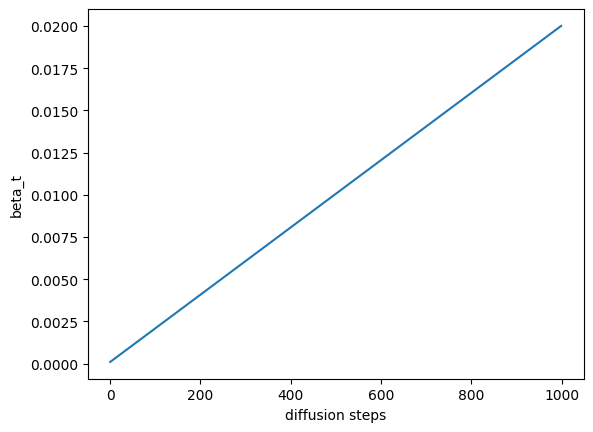

In [2]:
import matplotlib.pyplot as plt

beta_t, _ = linear_schedule()
plt.plot(beta_t)
plt.xlabel("diffusion steps")
plt.ylabel("beta_t")
plt.show()

### Cosine schedule
Alex Nichol and Prafulla Dhariwal proposed the cosine schedule to prevent an image from turning into noise too quickly. They construct a different noise schedule in terms of $\bar{\alpha}_{t}$.

$$
\bar{\alpha}_{t} = \frac{f(t)}{f(0)}, \quad f(t) = \cos \left( \frac{t/T+s}{1+s} \cdot \frac{\pi}{2}\right)^{2}
$$

By definition, the $\beta_{t}$ equals,

$$
\beta_{t} = 1 - \frac{\bar{\alpha}_{t}}{\bar{\alpha}_{t-1}}
$$


In practice, $\beta_{t}$ is clipped to be no larger than 0.999 to prevent singularities at the end of the diffusion process near $t=T$. The $s$ is an offset to prevent $\beta_{t}$ from being too small near $t=0$. They selected the $s$ as 0.008 which is slightly smaller than the pixel bin size $1/127.5$.
 

In [3]:
import math
import torch

def cosine_schedule(T=4000, s=0.008, beta_t_max=0.999):
    f_t = torch.square(torch.cos((math.pi/2)*(torch.linspace(0, 1, T+1).float()+s)/(1+s)))
    alphabar_t = f_t / f_t[0]
    beta_t = 1 - alphabar_t[1:]/alphabar_t[:-1]
    beta_t = torch.clip(beta_t, 0, beta_t_max)
    return beta_t, alphabar_t[1:]

The cosine scheduler makes $\bar{\alpha}_{t}$ decrease more slowly than the linear scheduler.

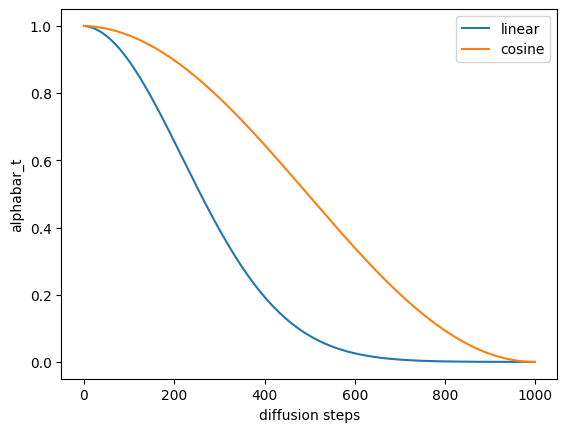

In [4]:
_, linear_alphabar_t = linear_schedule(T=1000)
_, cosine_alphabar_t = cosine_schedule(T=1000)

plt.plot(linear_alphabar_t, label="linear")
plt.plot(cosine_alphabar_t, label="cosine")
plt.xlabel("diffusion steps")
plt.ylabel("alphabar_t")
plt.legend()
plt.show()

### Example for an image

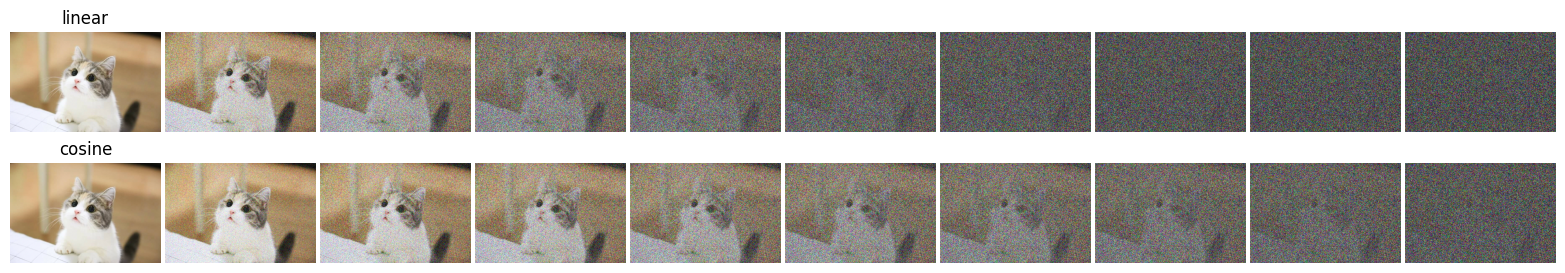

In [5]:
import cv2

img = cv2.imread("images/cat.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = torch.from_numpy(img).float() / 255.0

epsilon = torch.randn_like(img)

T = 1000
_, linear_alphabar_t = linear_schedule(T=T)
_, cosine_alphabar_t = cosine_schedule(T=T)

ts = torch.arange(0, T)[::100]

plt.figure(figsize=(20, 3))
for i, t in enumerate(ts):
    linear_img = torch.sqrt(linear_alphabar_t[t]) * img + torch.sqrt(1-linear_alphabar_t[t]) * epsilon
    linear_img = torch.clip(linear_img, 0, 1)
    plt.subplot(2, len(ts), i+1)
    if i == 0: plt.title("linear")
    plt.imshow(linear_img)
    plt.axis("off")
for i, t in enumerate(ts):
    cosine_img = torch.sqrt(cosine_alphabar_t[t]) * img + torch.sqrt(1-cosine_alphabar_t[t]) * epsilon
    cosine_img = torch.clip(cosine_img, 0, 1)
    plt.subplot(2, len(ts), i+len(ts)+1)
    if i == 0: plt.title("cosine")
    plt.imshow(cosine_img)
    plt.axis("off")

plt.subplots_adjust(wspace=0, hspace=0.3)
plt.show()

Noise image samples from linear (top) and cosine (bottom) schedules respectively. You can see that noise is applied slowly in the cosine schedule.